In [26]:
# basic imports for a Fourier Neural Operator
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam, AdamW
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [27]:
# import data as torch tensors from .txt files skipping the first row
train_val_data = np.loadtxt(
    "/Users/lorenzotarricone/Desktop/ETH/2nd_semester/AI in Science and Engineering /Project_2/Task1/TrainingData.txt",
    skiprows=1,
    delimiter=",",
)
train_val_data = torch.tensor(train_val_data, dtype=torch.float32)

test_data = np.loadtxt(
    "/Users/lorenzotarricone/Desktop/ETH/2nd_semester/AI in Science and Engineering /Project_2/Task1/TestingData.txt",
    skiprows=1,
    delimiter=",",
)
test_data = torch.tensor(test_data, dtype=torch.float32)

#Training and test data of the format [t, tf0, ts0]




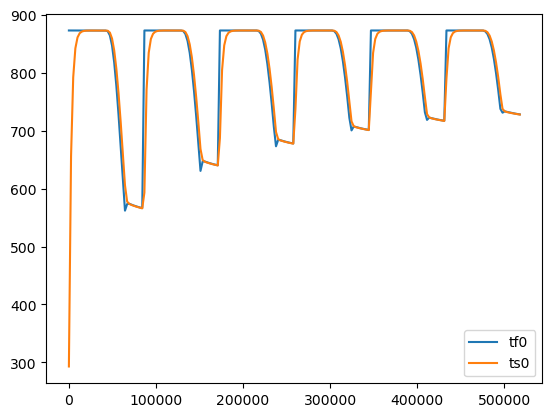

In [28]:
#plot train data to see the shape

plt.plot(train_val_data[:,0], train_val_data[:,1], label='tf0')
plt.plot(train_val_data[:,0], train_val_data[:,2], label='ts0')
plt.legend()
plt.show()


In [29]:
print("Same timestep within training set?", bool(train_val_data[:, 0][1] - train_val_data[:, 0][0] == train_val_data[:, 0][4] - train_val_data[:, 0][3]))
print("Well... as expected from the problem descrition")

Same timestep within training set? True
Well... as expected from the problem descrition


In [76]:
print("Same timestep within test set?", bool(test_data[1] - test_data[0] == test_data[4] - test_data[3]))

Same timestep within test set? True


In [31]:
print("Same timestep from training and test?", bool(train_val_data[:, 0][1] - train_val_data[:, 0][0] == test_data[4] - test_data[3]))
print(
    "For example: ",
    train_val_data[:, 0][7] - train_val_data[:, 0][6], test_data[4] - test_data[3])

print("Well... at least it's the same within the second decimal position. So maybe we can use a  FNO even if it is not a ReNO")

Same timestep from training and test? False
For example:  tensor(2478.0596) tensor(2478.0625)
Well... at least it's the same within the second decimal position. So maybe we can use a  FNO even if it is not a ReNO


----
## Approach 1: non-sliding windows

In [48]:
t_train = train_val_data[:, 0]
tf0_train = train_val_data[:, 1]
ts0_train = train_val_data[:, 2]

t_total = torch.cat((t_train, test_data), 0)

scaler_t = MinMaxScaler()
scaler_Tf = MinMaxScaler()
scaler_Ts = MinMaxScaler()

n_train = tf0_train.shape[0]
window_size = 35
batch_size = 2

assert n_train % window_size == 0, "The training data is not divisible by the window size"

t_total_norm = torch.tensor(
    scaler_t.fit_transform(t_total.reshape(-1, 1)), dtype=torch.float
)

Tf_norm = torch.tensor(
    scaler_Tf.fit_transform(tf0_train.reshape(-1, 1)),
    dtype=torch.float,
)
Ts_norm = torch.tensor(
    scaler_Ts.fit_transform(ts0_train.reshape(-1, 1)),
    dtype=torch.float,
)

diff_train_test_dim = t_total.shape[0] - t_train.shape[0]
t_tf_norm = torch.cat((t_total_norm[:-diff_train_test_dim], Tf_norm), 1)
t_ts_norm = torch.cat((t_total_norm[:-diff_train_test_dim], Ts_norm), 1)

t_tf_norm = t_tf_norm.reshape(-1, window_size, 2)
t_ts_norm = t_ts_norm.reshape(-1, window_size, 2)

t_tf_norm_input = t_tf_norm[:-1, :, :]
t_tf_norm_target = t_tf_norm[1:, :, 1]

t_ts_norm_input = t_ts_norm[:-1, :, :]
t_ts_norm_target = t_ts_norm[1:, :, 1]

# checing dimensions
print("t + Tf normalized input shape", t_tf_norm_input.shape)
print("Tf normalized target shape", t_tf_norm_target.shape)
print("t + Ts normalized input shape", t_ts_norm_input.shape)
print("Ts normalized target shape", t_ts_norm_target.shape)


training_Tf = DataLoader(
    TensorDataset(t_tf_norm_input, t_tf_norm_target),
    batch_size=batch_size,
    shuffle=True,
)
training_Ts = DataLoader(
    TensorDataset(t_ts_norm_input, t_ts_norm_target),
    batch_size=batch_size,
    shuffle=True,
)


t + Tf normalized input shape torch.Size([5, 35, 2])
t + Tf normalized target shape torch.Size([5, 35])
t + Ts normalized input shape torch.Size([5, 35, 2])
t + Ts normalized target shape torch.Size([5, 35])


In [49]:
def activation(name):
    if name in ["tanh", "Tanh"]:
        return nn.Tanh()
    elif name in ["relu", "ReLU"]:
        return nn.ReLU(inplace=True)
    elif name in ["lrelu", "LReLU"]:
        return nn.LeakyReLU(inplace=True)
    elif name in ["sigmoid", "Sigmoid"]:
        return nn.Sigmoid()
    elif name in ["softplus", "Softplus"]:
        return nn.Softplus(beta=4)
    elif name in ["celu", "CeLU"]:
        return nn.CELU()
    elif name in ["elu"]:
        return nn.ELU()
    elif name in ["mish"]:
        return nn.Mish()
    else:
        raise ValueError("Unknown activation function")


class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat)
        )

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-1) // 2 + 1,
            device=x.device,
            dtype=torch.cfloat,
        )
        out_ft[:, :, : self.modes1] = self.compl_mul1d(
            x_ft[:, :, : self.modes1], self.weights1
        )

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: leap time and measuremeents as the first time point (tj - ti, tf_i, ts_i)
        input shape: (batchsize, x=1, c=3)
        output: the solution at the second time point (tf_j, ts_j)
        output shape: (batchsize, x=1, c=2)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(
            2, self.width
        )  # input channel is 2: (u0(x), x) --> GRID IS INCLUDED!

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        # print("x after linear_p", x.shape)
        x = x.permute(0, 2, 1)
        # print("x after expansion", x.shape)

        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        # print("x after first layer", x.shape)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        # print("x after second layer", x.shape)
        x = self.fourier_layer(x, self.spect3, self.lin2)
        # print("x after third layer", x.shape)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        # print("x after contraction", x.shape)
        x = self.output_layer(x)
        return x




In [62]:
learning_rate = 0.001
epochs  = 1200
step_size = 100
gamma = 0.5

modes = 15
width = 100
fno_tf = FNO1d(modes, width)  # model
optimizer = Adam(fno_tf.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    print("TRAINING Tf")
    train_mse = 0.0
    train_l2_relative = 0.0

    for step, (input_batch, output_batch) in enumerate(training_Tf):
        optimizer.zero_grad()
        output_pred_batch = fno_tf(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
        train_l2_relative += (loss_f.item() / torch.mean(output_batch**2))**0.5 * 100
        
    train_mse /= len(training_Tf)
    train_l2_relative /= len(training_Tf)
    scheduler.step()
    
    if epoch % freq_print == 0:
        print(
            f"Epoch {epoch}, MSE: {train_mse}, Relative L2 error: {train_l2_relative}, lr: {scheduler.get_last_lr()}",
        )



TRAINING Tf
Epoch 0, MSE: 0.3031592095891635, Relative L2 error: 61.1400032043457, lr: [0.001]
TRAINING Tf
Epoch 1, MSE: 0.08222924607495467, Relative L2 error: 32.15696334838867, lr: [0.001]
TRAINING Tf
Epoch 2, MSE: 0.011320615691753725, Relative L2 error: 11.37063217163086, lr: [0.001]
TRAINING Tf
Epoch 3, MSE: 0.05457956405977408, Relative L2 error: 26.62288475036621, lr: [0.001]
TRAINING Tf
Epoch 4, MSE: 0.009448048891499639, Relative L2 error: 11.027127265930176, lr: [0.001]
TRAINING Tf
Epoch 5, MSE: 0.03140040176610152, Relative L2 error: 20.78265953063965, lr: [0.001]
TRAINING Tf
Epoch 6, MSE: 0.014026288564006487, Relative L2 error: 13.779376029968262, lr: [0.001]
TRAINING Tf
Epoch 7, MSE: 0.01822582756479581, Relative L2 error: 15.928372383117676, lr: [0.001]
TRAINING Tf
Epoch 8, MSE: 0.007501399222140511, Relative L2 error: 10.064772605895996, lr: [0.001]
TRAINING Tf
Epoch 9, MSE: 0.0069749136455357075, Relative L2 error: 9.501246452331543, lr: [0.001]
TRAINING Tf
Epoch 10, 

In [63]:
learning_rate = 0.001
epochs  = 1200
step_size = 100
gamma = 0.5

modes = 15
width = 100
fno_ts = FNO1d(modes, width)  # model
optimizer = Adam(fno_ts.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    print("TRAINING Ts")
    train_mse = 0.0
    train_l2_relative = 0.0

    for step, (input_batch, output_batch) in enumerate(training_Ts):
        optimizer.zero_grad()
        output_pred_batch = fno_ts(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
        train_l2_relative += (loss_f.item() / torch.mean(output_batch**2))**0.5 * 100
        
    train_mse /= len(training_Ts)
    train_l2_relative /= len(training_Ts)
    scheduler.step()
    
    if epoch % freq_print == 0:
        print(
            f"Epoch {epoch}, MSE: {train_mse}, Relative L2 error: {train_l2_relative}, lr: {scheduler.get_last_lr()}",
        )


TRAINING Ts
Epoch 0, MSE: 0.47050043443838757, Relative L2 error: 72.53266143798828, lr: [0.001]
TRAINING Ts
Epoch 1, MSE: 0.056915525967876114, Relative L2 error: 24.734426498413086, lr: [0.001]
TRAINING Ts
Epoch 2, MSE: 0.05215290483708183, Relative L2 error: 22.754302978515625, lr: [0.001]
TRAINING Ts
Epoch 3, MSE: 0.0388001361861825, Relative L2 error: 20.126039505004883, lr: [0.001]
TRAINING Ts
Epoch 4, MSE: 0.02069996817347904, Relative L2 error: 14.55489730834961, lr: [0.001]
TRAINING Ts
Epoch 5, MSE: 0.010623061641429862, Relative L2 error: 10.692936897277832, lr: [0.001]
TRAINING Ts
Epoch 6, MSE: 0.018767159121731918, Relative L2 error: 15.056191444396973, lr: [0.001]
TRAINING Ts
Epoch 7, MSE: 0.008561099879443645, Relative L2 error: 10.212860107421875, lr: [0.001]
TRAINING Ts
Epoch 8, MSE: 0.01149966660887003, Relative L2 error: 11.8153657913208, lr: [0.001]
TRAINING Ts
Epoch 9, MSE: 0.0066595108558734255, Relative L2 error: 8.951990127563477, lr: [0.001]
TRAINING Ts
Epoch 10

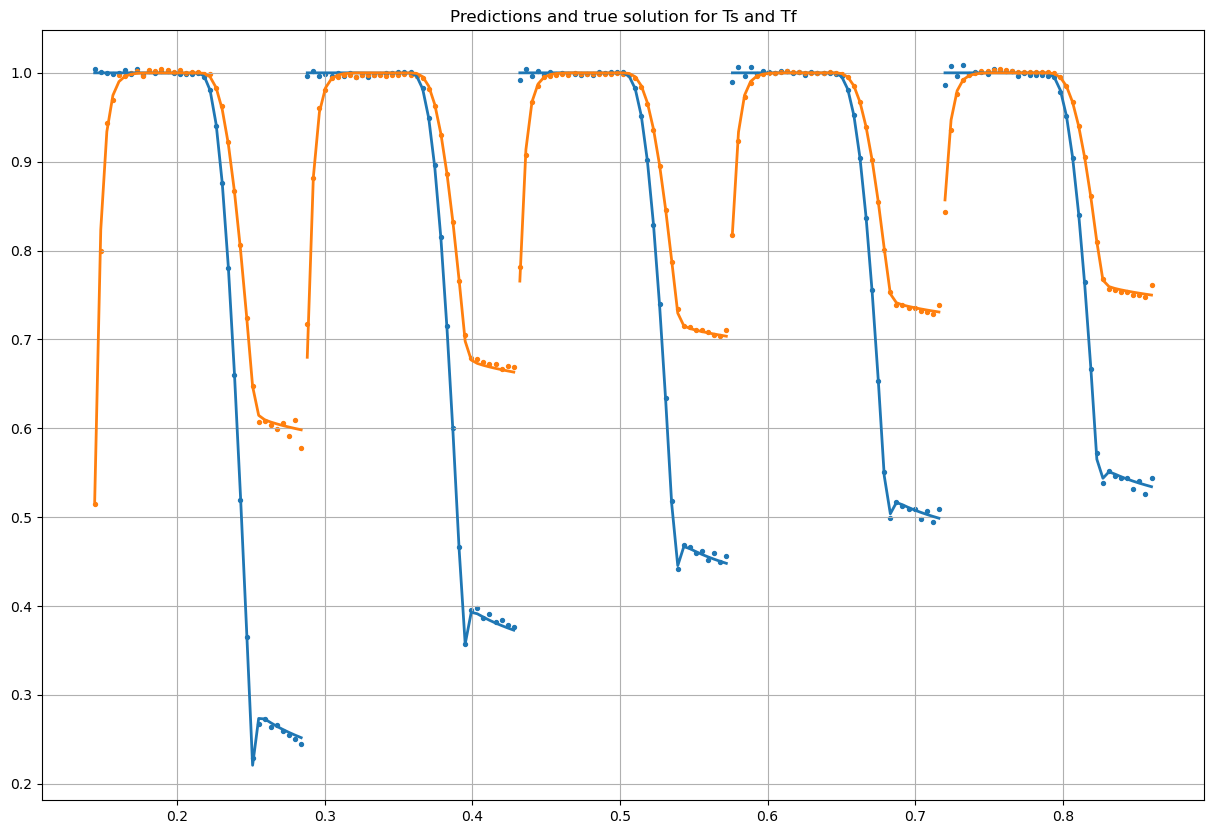

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.grid()
ax.set_title("Predictions and true solution for Ts and Tf")

# fig.figure(dpi=250)
# fig.grid(True, which="both", ls=":")

# Plot fno_Tf & fno_Ts
assert t_tf_norm.shape[0] == t_ts_norm.shape[0]

for i in range(t_tf_norm_input.shape[0]):

    input_function_test_Tf = t_tf_norm_input[i, :].unsqueeze(0)
    output_function_test_Tf = t_tf_norm_target[i, :].unsqueeze(0)

    input_function_test_Ts = t_ts_norm_input[i, :].unsqueeze(0)
    output_function_test_Ts = t_ts_norm_target[i, :].unsqueeze(0)


    output_function_test_pred_Tf = fno_tf(input_function_test_Tf)
    output_function_test_pred_Ts = fno_ts(input_function_test_Ts)

    ax.plot(
        t_tf_norm[i + 1, :][:, 0].detach(),
        output_function_test_Tf[0].detach(),
        label="True Solution Tf",
        c="C0",
        lw=2,
    )
    ax.scatter(
        t_tf_norm[i + 1, :][:, 0].detach(),
        output_function_test_pred_Tf[0].detach(),
        label="Approximate Solution Tf",
        s=8,
        c="C0",
    )

    ax.plot(
        t_ts_norm[i + 1, :][:, 0].detach(),
        output_function_test_Ts[0].detach(),
        label="True Solution Ts",
        c="C1",
        lw=2,
    )
    ax.scatter(
        t_ts_norm[i + 1, :][:, 0].detach(),
        output_function_test_pred_Ts[0].detach(),
        label="Approximate Solution Ts",
        s=8,
        c="C1",
    )

plt.show()

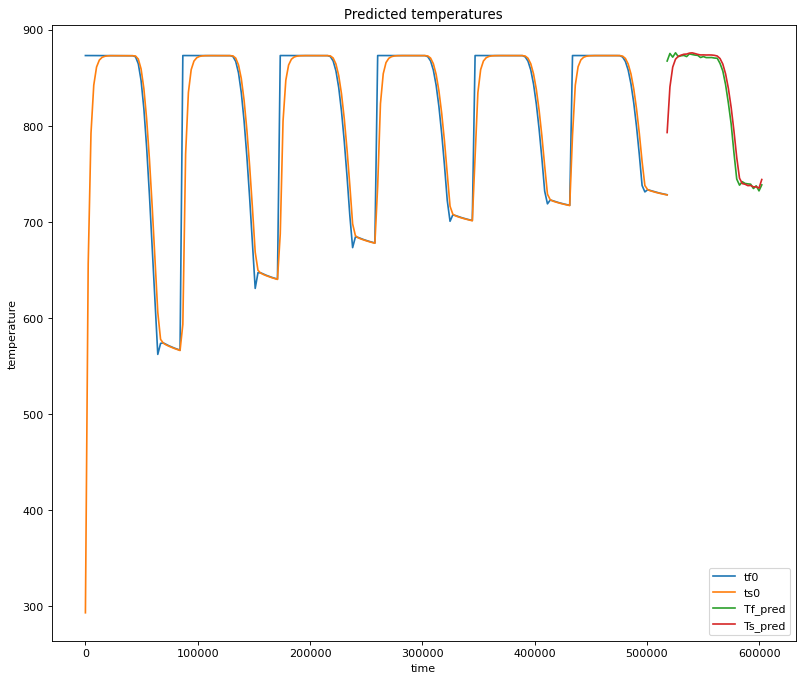

In [65]:
plt.figure(figsize=(12, 10), dpi=80)


input_Tf_pred = t_tf_norm[-1, :].unsqueeze(0)
input_Ts_pred = t_ts_norm[-1, :].unsqueeze(0)


output_pred_Tf = fno_tf(input_Tf_pred).squeeze()
output_pred_Ts = fno_ts(input_Ts_pred).squeeze()

# Prediction on the test data in the original scale
output_pred_Tf_org = scaler_Tf.inverse_transform(output_pred_Tf.detach().reshape(-1, 1))
output_pred_Ts_org = scaler_Ts.inverse_transform(output_pred_Ts.detach().reshape(-1, 1))


output_pred_Tf_train = fno_tf(t_tf_norm_input)
output_pred_Ts_train = fno_ts(t_tf_norm_input)


plt.plot(train_val_data[:, 0], train_val_data[:, 1], label="tf0")
plt.plot(train_val_data[:, 0], train_val_data[:, 2], label="ts0")


plt.plot(t_total[-35:], output_pred_Tf_org, label="Tf_pred")
plt.plot(t_total[-35:], output_pred_Ts_org, label="Ts_pred")

plt.xlabel("time")
plt.ylabel("temperature")
plt.legend()
plt.title("Predicted temperatures")


plt.show()

-------
### Approach 2: overlapping windows



In [39]:
#### NEW VERSION ###
t_train = train_val_data[:, 0]
tf0_train = train_val_data[:, 1]
ts0_train = train_val_data[:, 2]

t_total = torch.cat((t_train, test_data), 0)
t_total.shape

scaler_t = MinMaxScaler()
scaler_Tf = MinMaxScaler()
scaler_Ts = MinMaxScaler()

n_train = tf0_train.shape[0]
window_size = 35
batch_size = 4
perc_stride = 0.5

assert (n_train - window_size) % (window_size * perc_stride) == 0, "Select a window size and perc_stride that allow for a perfect division of the dataset"

t_total_norm = torch.tensor(
    scaler_t.fit_transform(t_total.reshape(-1, 1)), dtype=torch.float
)

Tf_norm = torch.tensor(
    scaler_Tf.fit_transform(tf0_train.reshape(-1, 1)),
    dtype=torch.float,
)
Ts_norm = torch.tensor(
    scaler_Ts.fit_transform(ts0_train.reshape(-1, 1)),
    dtype=torch.float,
)

def create_sliding_windows(data_tensor, window_size, perc_stride):
    n_rows = data_tensor.shape[0]
    n_cols = data_tensor.shape[1]
    n_windows = int((n_rows - window_size) / (window_size * perc_stride) + 1)
    windows = torch.zeros(n_windows, window_size, n_cols)
    for i in range(n_windows):
        windows[i] = data_tensor[int(i * window_size * perc_stride):int(i * window_size * perc_stride + window_size)]
    return windows

diff_train_test_dim = t_total.shape[0] - t_train.shape[0]

# Reunite the tensor with the normalized data
t_Tf_Ts_norm = torch.cat((t_total_norm[:-diff_train_test_dim], Tf_norm, Ts_norm), 1)

# Create sliding windows for that dataset
train_val_windows = create_sliding_windows(t_Tf_Ts_norm, window_size, perc_stride)

# Divide target and data for the whole dataset
t_tf_norm = train_val_windows[:, :, :2]
t_ts_norm = train_val_windows[:, :, ::2]
t_tf_norm_input = train_val_windows[:-1, :, :2]
t_tf_norm_target = train_val_windows[1:, :, 1]
t_ts_norm_input = train_val_windows[:-1, : , ::2]
t_ts_norm_target = train_val_windows[1:, :, 2]

# checing dimensions
print("t + Tf normalized input shape", t_tf_norm_input.shape)
print("t + Tf normalized target shape", t_tf_norm_target.shape)
print("t + Ts normalized input shape", t_ts_norm_input.shape)
print("t + Ts normalized target shape", t_ts_norm_target.shape)


training_Tf = DataLoader(
    TensorDataset(t_tf_norm_input, t_tf_norm_target),
    batch_size=batch_size,
    shuffle=True,
)
training_Ts = DataLoader(
    TensorDataset(t_ts_norm_input, t_ts_norm_target),
    batch_size=batch_size,
    shuffle=True,
)

t + Tf normalized input shape torch.Size([10, 35, 2])
t + Tf normalized target shape torch.Size([10, 35])
t + Ts normalized input shape torch.Size([10, 35, 2])
t + Ts normalized target shape torch.Size([10, 35])


## FNO Architecture

In [40]:
def activation(name):
    if name in ["tanh", "Tanh"]:
        return nn.Tanh()
    elif name in ["relu", "ReLU"]:
        return nn.ReLU(inplace=True)
    elif name in ["lrelu", "LReLU"]:
        return nn.LeakyReLU(inplace=True)
    elif name in ["sigmoid", "Sigmoid"]:
        return nn.Sigmoid()
    elif name in ["softplus", "Softplus"]:
        return nn.Softplus(beta=4)
    elif name in ["celu", "CeLU"]:
        return nn.CELU()
    elif name in ["elu"]:
        return nn.ELU()
    elif name in ["mish"]:
        return nn.Mish()
    else:
        raise ValueError("Unknown activation function")

In [41]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat)
        )

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-1) // 2 + 1,
            device=x.device,
            dtype=torch.cfloat,
        )
        out_ft[:, :, : self.modes1] = self.compl_mul1d(
            x_ft[:, :, : self.modes1], self.weights1
        )

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

In [42]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: leap time and measuremeents as the first time point (tj - ti, tf_i, ts_i)
        input shape: (batchsize, x=1, c=3)
        output: the solution at the second time point (tf_j, ts_j)
        output shape: (batchsize, x=1, c=2)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(
            2, self.width
        )  # input channel is 2: (u0(x), x) --> GRID IS INCLUDED!

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        # print("x after linear_p", x.shape)
        x = x.permute(0, 2, 1)
        # print("x after expansion", x.shape)

        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        # print("x after first layer", x.shape)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        # print("x after second layer", x.shape)
        x = self.fourier_layer(x, self.spect3, self.lin2)
        # print("x after third layer", x.shape)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        # print("x after contraction", x.shape)
        x = self.output_layer(x)
        return x

In [43]:
learning_rate = 0.001
epochs = 350
step_size = 100
gamma = 0.5

modes = 5
width = 100
fno_tf = FNO1d(modes, width)  # model
optimizer = Adam(fno_tf.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    print("TRAINING Tf")
    train_mse = 0.0
    train_l2_relative = 0.0

    for step, (input_batch, output_batch) in enumerate(training_Tf):
        optimizer.zero_grad()
        output_pred_batch = fno_tf(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
        train_l2_relative += (loss_f.item() / torch.mean(output_batch**2)) ** 0.5 * 100

    train_mse /= len(training_Tf)
    train_l2_relative /= len(training_Tf)
    scheduler.step()

    if epoch % freq_print == 0:
        print(
            f"Epoch {epoch}, MSE: {train_mse}, Relative L2 error: {train_l2_relative}, lr: {scheduler.get_last_lr()}",
        )

TRAINING Tf
Epoch 0, MSE: 0.29868260274330777, Relative L2 error: 61.676517486572266, lr: [0.001]
TRAINING Tf
Epoch 1, MSE: 0.08752299348513286, Relative L2 error: 34.661556243896484, lr: [0.001]
TRAINING Tf
Epoch 2, MSE: 0.02505554382999738, Relative L2 error: 18.440710067749023, lr: [0.001]
TRAINING Tf
Epoch 3, MSE: 0.04852550725142161, Relative L2 error: 25.628408432006836, lr: [0.001]
TRAINING Tf
Epoch 4, MSE: 0.015023191459476948, Relative L2 error: 14.287222862243652, lr: [0.001]
TRAINING Tf
Epoch 5, MSE: 0.02928495469192664, Relative L2 error: 20.382305145263672, lr: [0.001]
TRAINING Tf
Epoch 6, MSE: 0.010894551873207092, Relative L2 error: 12.395912170410156, lr: [0.001]
TRAINING Tf
Epoch 7, MSE: 0.017002372071146965, Relative L2 error: 15.445784568786621, lr: [0.001]
TRAINING Tf
Epoch 8, MSE: 0.009789166661600271, Relative L2 error: 11.446002006530762, lr: [0.001]
TRAINING Tf
Epoch 9, MSE: 0.009703644240895907, Relative L2 error: 11.648152351379395, lr: [0.001]
TRAINING Tf
Epo

In [44]:
learning_rate = 0.001
epochs  = 350
step_size = 100
gamma = 0.5

modes = 5
width = 100
fno_ts = FNO1d(modes, width)  # model
optimizer = Adam(fno_ts.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    print("TRAINING Ts")
    train_mse = 0.0
    train_l2_relative = 0.0

    for step, (input_batch, output_batch) in enumerate(training_Ts):
        optimizer.zero_grad()
        output_pred_batch = fno_ts(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
        train_l2_relative += (loss_f.item() / torch.mean(output_batch**2))**0.5 * 100
        
    train_mse /= len(training_Ts)
    train_l2_relative /= len(training_Ts)
    scheduler.step()
    
    if epoch % freq_print == 0:
        print(
            f"Epoch {epoch}, MSE: {train_mse}, Relative L2 error: {train_l2_relative}, lr: {scheduler.get_last_lr()}",
        )

TRAINING Ts
Epoch 0, MSE: 0.3085132787624995, Relative L2 error: 57.62386703491211, lr: [0.001]
TRAINING Ts
Epoch 1, MSE: 0.07405455348392327, Relative L2 error: 29.5013370513916, lr: [0.001]
TRAINING Ts
Epoch 2, MSE: 0.02539960201829672, Relative L2 error: 16.54432487487793, lr: [0.001]
TRAINING Ts
Epoch 3, MSE: 0.040751259153087936, Relative L2 error: 22.41730308532715, lr: [0.001]
TRAINING Ts
Epoch 4, MSE: 0.005330848352362712, Relative L2 error: 7.8258137702941895, lr: [0.001]
TRAINING Ts
Epoch 5, MSE: 0.017691538358728092, Relative L2 error: 14.835952758789062, lr: [0.001]
TRAINING Ts
Epoch 6, MSE: 0.005933489417657256, Relative L2 error: 8.099625587463379, lr: [0.001]
TRAINING Ts
Epoch 7, MSE: 0.006050421390682459, Relative L2 error: 8.48980712890625, lr: [0.001]
TRAINING Ts
Epoch 8, MSE: 0.006260904328276713, Relative L2 error: 8.652348518371582, lr: [0.001]
TRAINING Ts
Epoch 9, MSE: 0.0018440046502898137, Relative L2 error: 4.761355876922607, lr: [0.001]
TRAINING Ts
Epoch 10, M

In [389]:
t_tf_norm_input.shape

torch.Size([10, 35, 2])

-----

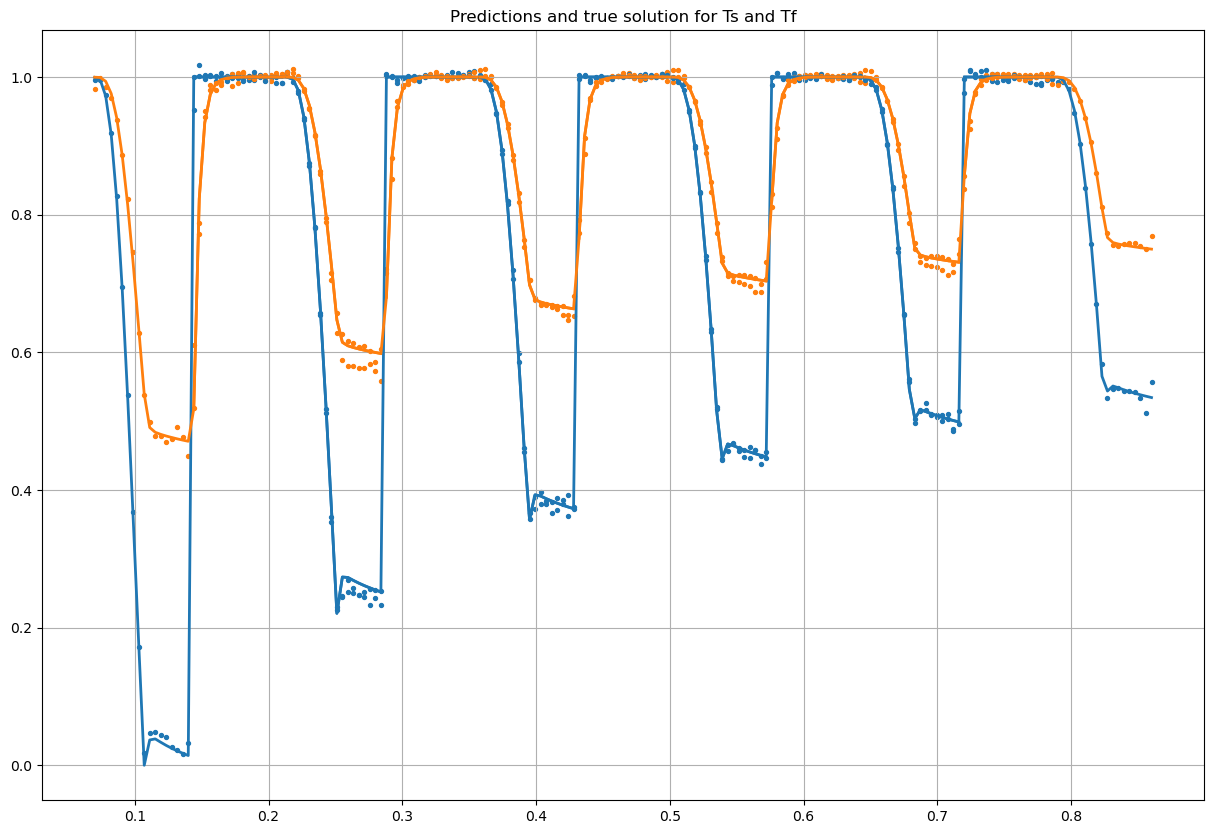

In [45]:
#Plotting

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.grid()
ax.set_title("Predictions and true solution for Ts and Tf")

# fig.figure(dpi=250)
# fig.grid(True, which="both", ls=":")

# Plot fno_Tf & fno_Ts
assert t_tf_norm.shape[0] == t_ts_norm.shape[0]

for i in range(t_tf_norm_input.shape[0]):

    input_function_test_Tf = t_tf_norm_input[i, :].unsqueeze(0)
    output_function_test_Tf = t_tf_norm_target[i, :].unsqueeze(0)

    input_function_test_Ts = t_ts_norm_input[i, :].unsqueeze(0)
    output_function_test_Ts = t_ts_norm_target[i, :].unsqueeze(0)

    output_function_test_pred_Tf = fno_tf(input_function_test_Tf)
    output_function_test_pred_Ts = fno_ts(input_function_test_Ts)

    ax.plot(
        t_tf_norm[i + 1, :][:, 0].detach(),
        output_function_test_Tf[0].detach(),
        label="True Solution Tf",
        c="C0",
        lw=2,
    )
    ax.scatter(
        t_tf_norm[i + 1, :][:, 0].detach(),
        output_function_test_pred_Tf[0].detach(),
        label="Approximate Solution Tf",
        s=8,
        c="C0",
    )

    ax.plot(
        t_ts_norm[i + 1, :][:, 0].detach(),
        output_function_test_Ts[0].detach(),
        label="True Solution Ts",
        c="C1",
        lw=2,
    )
    ax.scatter(
        t_ts_norm[i + 1, :][:, 0].detach(),
        output_function_test_pred_Ts[0].detach(),
        label="Approximate Solution Ts",
        s=8,
        c="C1",
    )

plt.show()

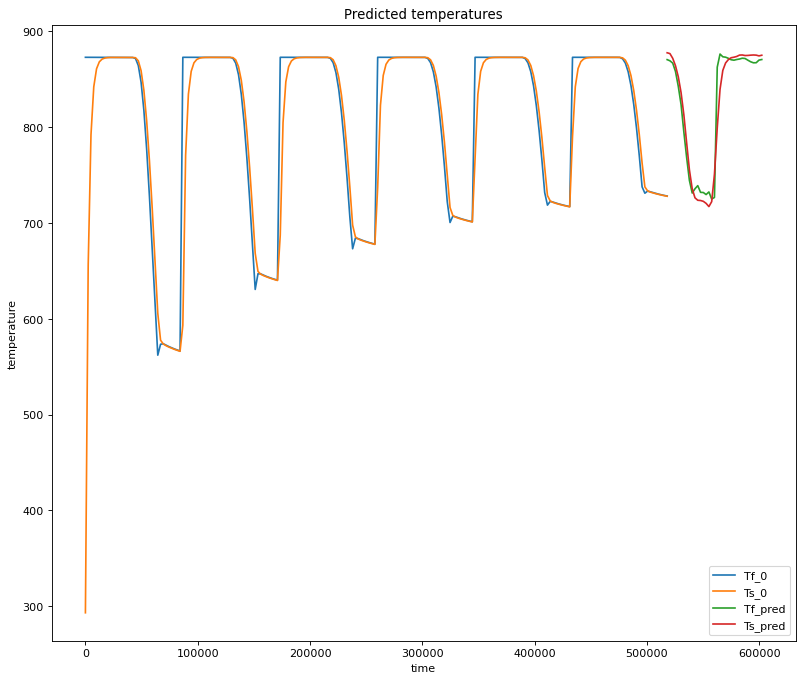

In [47]:
plt.figure(figsize=(12, 10), dpi=80)


input_Tf_pred = t_tf_norm[-1, :].unsqueeze(0)
input_Ts_pred = t_ts_norm[-1, :].unsqueeze(0)


output_pred_Tf = fno_tf(input_Tf_pred).squeeze()
output_pred_Ts = fno_ts(input_Ts_pred).squeeze()

# Prediction on the test data in the original scale
output_pred_Tf_org = scaler_Tf.inverse_transform(output_pred_Tf.detach().reshape(-1, 1))
output_pred_Ts_org = scaler_Ts.inverse_transform(output_pred_Ts.detach().reshape(-1, 1))


output_pred_Tf_train = fno_tf(t_tf_norm_input)
output_pred_Ts_train = fno_ts(t_tf_norm_input)



plt.plot(train_val_data[:,0], train_val_data[:,1], label='Tf_0')
plt.plot(train_val_data[:,0], train_val_data[:,2], label='Ts_0')


plt.plot(t_total[-35:], output_pred_Tf_org, label="Tf_pred")
plt.plot(t_total[-35:], output_pred_Ts_org, label="Ts_pred")

plt.xlabel("time")
plt.ylabel("temperature")
plt.legend()
plt.title("Predicted temperatures")


plt.show()

-----
### Saving results

Given the results above, the networks trained on non overlapping windows seem to be the ones that perform better. This is why I'm going to use them for the predictions

In [70]:
print("Size of the predictions", output_pred_Tf_org.shape, output_pred_Ts_org.shape)
print("Size of the test data", test_data.shape)

Size of the predictions (35, 1) (35, 1)
Size of the test data torch.Size([34])


In [77]:
test_data

tensor([520392.5938, 522870.6562, 525348.7500, 527826.7500, 530304.8125,
        532782.8750, 535260.9375, 537739.0000, 540217.0625, 542695.1250,
        545173.1875, 547651.2500, 550129.3125, 552607.3750, 555085.4375,
        557563.5000, 560041.5625, 562519.6250, 564997.6875, 567475.7500,
        569953.8125, 572431.8750, 574909.9375, 577388.0000, 579866.0625,
        582344.1250, 584822.1875, 587300.2500, 589778.2500, 592256.3125,
        594734.3750, 597212.4375, 599690.5000, 602168.5625])

In [78]:
t_total[-35:]

tensor([517914.5312, 520392.5938, 522870.6562, 525348.7500, 527826.7500,
        530304.8125, 532782.8750, 535260.9375, 537739.0000, 540217.0625,
        542695.1250, 545173.1875, 547651.2500, 550129.3125, 552607.3750,
        555085.4375, 557563.5000, 560041.5625, 562519.6250, 564997.6875,
        567475.7500, 569953.8125, 572431.8750, 574909.9375, 577388.0000,
        579866.0625, 582344.1250, 584822.1875, 587300.2500, 589778.2500,
        592256.3125, 594734.3750, 597212.4375, 599690.5000, 602168.5625])

By inspecting the data we see that we need to discard the very first point

In [80]:
test_data_Tf = output_pred_Tf_org[-34:]
test_data_Ts = output_pred_Ts_org[-34:]

test_data_Tf.shape, test_data.shape

((34, 1), torch.Size([34]))

In [82]:
# save the results in a .txt file with the same format as the input file
# the first row contains the headers t, tf, ts
# the following rows contain the values of t, tf, ts


def save_results(file_name, test_data, test_data_Tf, test_data_Ts):
    with open(file_name, "w") as f:
        f.write("t,tf0,ts0\n")
        for i in range(len(test_data)):
            f.write(
                f"{test_data[i]},{test_data_Tf[i][0]},{test_data_Ts[i][0]}\n"
            )


save_results(
    "/Users/lorenzotarricone/Desktop/ETH/2nd_semester/AI in Science and Engineering /Project_2/Task1.txt",
    test_data,
    test_data_Tf,
    test_data_Ts,
)